## 2.3 Consulte en qué consisten los class activation maps (CAM) y su aplicabilidad para interpretar los resultados de clasificación de imágenes con redes neuronales. Proponga un modelo de clasificación de la base de datos Fashion Mnist con regularización, por autoencoders. Presente una simulación para el método GradCam++ en al menos tres capas de la red propuesta para dos clases de prueba. Nota: se sugiere utilizar el paquete keras-vis: https://raghakot.github.io/keras-vis/.

Los Class Activation Maps (CAM) son una técnica que permite visualizar las regiones de una imagen que son más relevantes para una red neuronal en la toma de decisiones para la clasificación de una clase específica. Esto se logra ponderando las características de la última capa convolucional por la importancia de la clase, lo cual genera un mapa de activación que resalta las áreas significativas de la imagen, significa que se utilizan los valores de activación de esta capa, combinados con los pesos de la capa de salida correspondiente a la clase de interés, para generar un mapa de importancia.

Última Capa Convolucional: Produce múltiples mapas de características, donde cada mapa resalta ciertas características o patrones presentes en la imagen de entrada.

Pesos de la Capa de Salida: La capa de salida de la red neuronal es típicamente una capa densa con una neurona por cada clase de la tarea de clasificación. Los pesos que conectan las neuronas de la última capa convolucional con la neurona de la clase. 

Ponderación: Para generar el CAM, se toma un promedio ponderado de los mapas de características de la última capa convolucional, utilizando los pesos de la capa de salida correspondientes a la clase de interés como factores de ponderación. Esto se hace multiplicando cada mapa de características por su peso respectivo y luego sumando los resultados.

Mapa de Activación: El resultado es un mapa de activación que resalta las áreas de la imagen original que más influyen en la predicción de la clase específica. Las regiones con valores más altos en el mapa indican las áreas de la imagen que tuvieron mayor influencia en la decisión de la red.

***Aplicabilidad: ***

**Interpretabilidad:** Los CAM ayudan a entender y explicar por qué la red neuronal toma ciertas decisiones, identificando visualmente las características de la imagen que más influyen en la predicción.

**Depuración del Modelo:** Permiten verificar si el modelo está aprendiendo las características correctas, lo cual es útil para identificar y corregir posibles problemas en el entrenamiento y en los datos.

**Confianza en el Modelo:** Mejoran la confianza de los usuarios en el modelo al proporcionar una explicación visual de las predicciones, especialmente en aplicaciones críticas como la medicina.

**Diagnóstico y Mejora:** Ayudan a detectar sesgos y a realizar ajustes en el modelo para mejorar su rendimiento y robustez, asegurando que las predicciones sean basadas en características relevantes y no en ruidos o patrones irrelevantes.

In [1]:
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models

  Cloning https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models to /tmp/pip-req-build-v5770v58
  Running command git clone --filter=blob:none --quiet https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models /tmp/pip-req-build-v5770v58
  Resolved https://github.com/UN-GCPDS/python-gcpds.EEG_Tensorflow_models to commit 975885b1f6814fd5958199919b33e02a6a9aa152
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 kB 2.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.7/230.7 kB 5.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 13.2 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.7/234.7 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 58.5 MB/s eta 0:00:00
  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

import tensorflow as tf
from tensorflow.keras import layers, models, initializers, regularizers, backend as K
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Lambda, Reshape, Conv2DTranspose, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy, MeanSquaredError
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.utils import plot_model

2024-08-12 08:02:12.212043: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 08:02:12.212134: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 08:02:12.316504: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def compare_images(original_images, predicted_images, true_labels, label_names, indices, images_per_row=6, figsize=(12, 8)):
    """
    Función para comparar visualmente imágenes originales con las predicciones, mostrando también las etiquetas verdaderas.
    
    Args:
    original_images (numpy.array): Array de imágenes originales.
    predicted_images (numpy.array): Array de imágenes reconstruidas por el modelo, con la forma (n_samples, height, width, channels).
    true_labels (numpy.array): Array de etiquetas verdaderas para las imágenes originales.
    label_names (list): Lista de nombres de etiquetas correspondientes a las clases.
    indices (list of int): Lista de índices de las imágenes a comparar.
    images_per_row (int): Cantidad de imágenes por fila.
    figsize (tuple): Tamaño de la figura de matplotlib.
    """
    num_images = len(indices)
    rows = (num_images + images_per_row - 1) // images_per_row  # Calcular número de filas necesarias
    
    plt.figure(figsize=figsize)
    
    for i, index in enumerate(indices):
        # Mostrar imagen original
        plt.subplot(2 * rows, images_per_row, i + 1)
        plt.imshow(original_images[index].squeeze(), cmap='gray')
        plt.title(f'Original {index}\nLabel: {label_names[true_labels[index]]}')
        plt.axis('off')

        # Mostrar imagen predicha
        plt.subplot(2 * rows, images_per_row, i + 1 + rows * images_per_row)
        plt.imshow(predicted_images[index].squeeze(), cmap='gray')
        plt.title(f'Reconstrucción {index}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [4]:
# Cargar el dataset
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalizar los datos
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255

# Añadir canal de color
X_train_full = np.expand_dims(X_train_full, -1)
X_test = np.expand_dims(X_test, -1)

# Dividir los datos en conjunto de entrenamiento y validación
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:] 

4422102/4422102 [==============================] - 0s 0us/step


In [5]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Flatten, Dense, Dropout, Reshape, BatchNormalization
import tensorflow.keras.backend as K
import numpy as np

def model_ae_class(input_shape=(28, 28, 1), num_classes=10, l2_lambda=0.001):
    # Encoder
    inputs = layers.Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', 
               kernel_regularizer=regularizers.l2(l2_lambda), name='conv1')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', strides=(2, 2), 
               kernel_regularizer=regularizers.l2(l2_lambda), name='conv2')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', 
               kernel_regularizer=regularizers.l2(l2_lambda), name='conv3')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', 
               kernel_regularizer=regularizers.l2(l2_lambda), name="penultimate_conv_layer")(x)
    x = BatchNormalization()(x)
    shape_before_flattening = K.int_shape(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    latent_space = Dense(128, kernel_regularizer=regularizers.l2(l2_lambda), name="latent_space")(x)
    softmax_output = layers.Dense(num_classes, activation='softmax', 
                                  kernel_regularizer=regularizers.l2(l2_lambda), name='softmax_output')(latent_space)

    # Decoder
    x = Dense(np.prod(shape_before_flattening[1:]), activation='relu', 
              kernel_regularizer=regularizers.l2(l2_lambda))(latent_space)
    x = Reshape(shape_before_flattening[1:])(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same', 
                        kernel_regularizer=regularizers.l2(l2_lambda), name='deconv1')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same', 
                        kernel_regularizer=regularizers.l2(l2_lambda), name='deconv2')(x)
    x = BatchNormalization()(x)
    x = Conv2DTranspose(64, (3, 3), activation='relu', strides=(2, 2), padding='same', 
                        kernel_regularizer=regularizers.l2(l2_lambda), name='deconv3')(x)
    x = BatchNormalization()(x)
    decoded = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same', 
                              kernel_regularizer=regularizers.l2(l2_lambda), name='output')(x)

    autoencoder = models.Model(inputs, [decoded, softmax_output], name='ae')
    return autoencoder

"""
    Crea un modelo de autoencoder convolucional que combina una arquitectura de clasificación con una reconstrucción de imagen.

    Parámetros:
    -----------
    input_shape : tuple, opcional
        La forma de entrada de las imágenes (por defecto es (28, 28, 1)).
    num_classes : int, opcional
        El número de clases para la salida softmax del clasificador (por defecto es 10).
    l2_lambda : float, opcional
        El parámetro de regularización L2 para todas las capas (por defecto es 0.001).

    Devuelve:
    ---------
    autoencoder : tf.keras.Model
        Un modelo de Keras que toma una imagen como entrada y produce dos salidas:
        1. La imagen reconstruida.
        2. Las probabilidades de clasificación sobre `num_classes` clases.

    Notas:
    ------
    - El modelo tiene dos componentes principales: 
      1. El codificador, que reduce la dimensionalidad de la entrada y produce una representación en el espacio latente.
      2. El decodificador, que reconstruye la imagen original desde la representación en el espacio latente.
    - Adicionalmente, el modelo incluye una capa softmax que clasifica la imagen en una de las `num_classes` clases.
    - Se emplea la regularización L2 para prevenir el sobreajuste en todas las capas convolucionales y densas.
    """


In [ ]:
#Crear el modelo
autoencoder = model_ae_class()
## Generar y guardar la visualización de la arquitectura del modelo
plot_model(autoencoder, to_file='autoencoder_with_classification.png', show_shapes=True, show_layer_names=True)

In [ ]:
autoencoder.summary()

In [ ]:
# Compilar el modelo con dos pérdidas: una para la reconstrucción y otra para la clasificación
autoencoder.compile(optimizer='adam', 
                    loss={'output': 'binary_crossentropy', 'softmax_output': 'sparse_categorical_crossentropy'},
                    metrics={'output': 'mse', 'softmax_output': 'accuracy'})

In [9]:
history = autoencoder.fit(X_train,[X_train, y_train],
                          epochs=100, batch_size=128, shuffle=True,
                          validation_data=(X_valid,[X_valid, y_valid])
                         )

Epoch 1/100


I0000 00:00:1723449750.619726     159 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


430/430 [==============================] - 21s 25ms/step - loss: 2.0648 - output_loss: 0.3299 - softmax_output_loss: 1.1457 - output_mse: 0.0291 - softmax_output_accuracy: 0.8197 - val_loss: 2.7904 - val_output_loss: 0.5156 - val_softmax_output_loss: 1.7650 - val_output_mse: 0.0909 - val_softmax_output_accuracy: 0.4780
Epoch 2/100
430/430 [==============================] - 9s 22ms/step - loss: 1.0840 - output_loss: 0.2954 - softmax_output_loss: 0.3305 - output_mse: 0.0182 - softmax_output_accuracy: 0.8887 - val_loss: 0.9551 - val_output_loss: 0.2932 - val_softmax_output_loss: 0.2564 - val_output_mse: 0.0165 - val_softmax_output_accuracy: 0.9106
Epoch 3/100
430/430 [==============================] - 9s 22ms/step - loss: 0.9039 - output_loss: 0.2872 - softmax_output_loss: 0.2569 - output_mse: 0.0155 - softmax_output_accuracy: 0.9053 - val_loss: 0.8767 - val_output_loss: 0.2840 - val_softmax_output_loss: 0.2727 - val_output_mse: 0.0138 - val_softmax_output_accuracy: 0.9024
Epoch 4/100
430

In [10]:
loss= history.history['loss']
val_loss= history.history['val_loss']

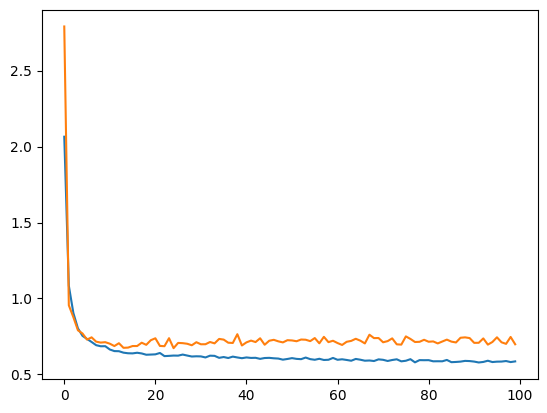

In [11]:
plt.plot(loss)
plt.plot(val_loss)

In [12]:
salida_modelo = autoencoder.predict(X_valid)

157/157 [==============================] - 1s 2ms/step


In [13]:
len(salida_modelo)

2

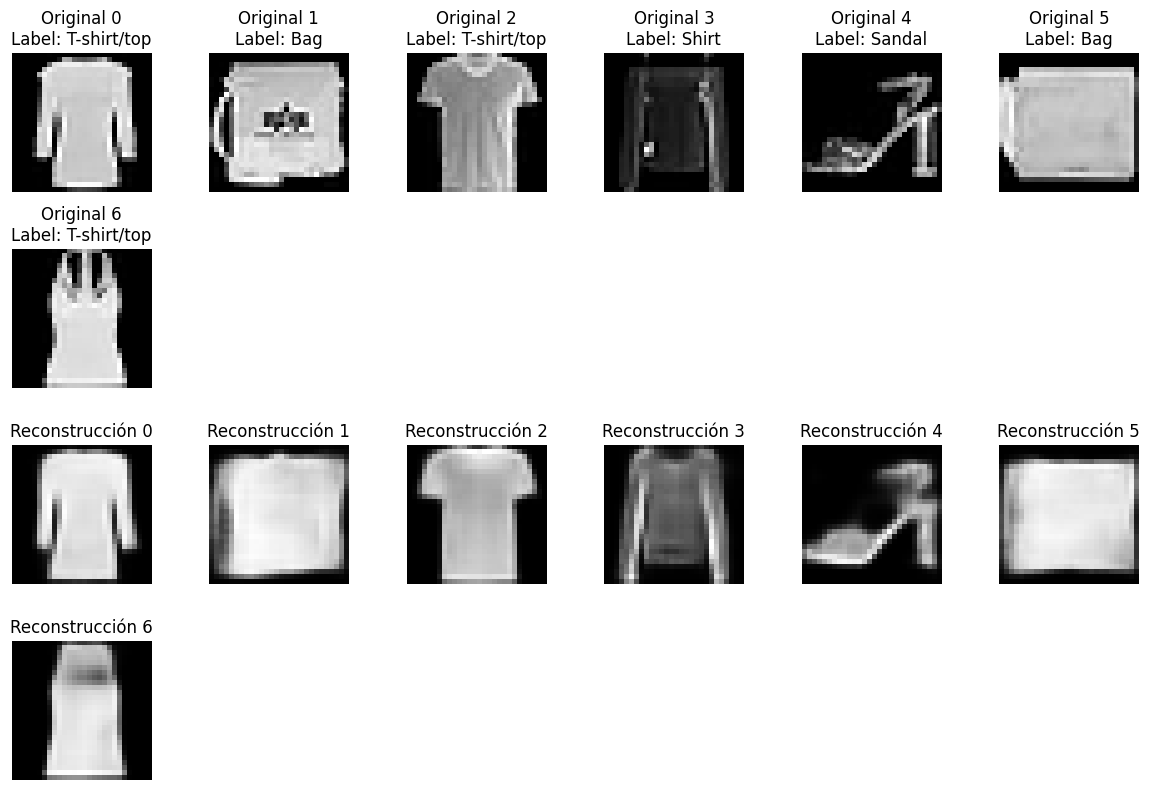

In [14]:
num_samples = 7
indices_to_compare = [i for i in range(num_samples)] 

# Nombres de etiquetas para el dataset Fashion MNIST
label_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

compare_images(X_valid,salida_modelo[0], y_valid, label_names, indices_to_compare)


In [15]:
# Obtén las predicciones de clasificación
softmax_output = salida_modelo[1]  
predicted_labels = np.argmax(softmax_output, axis=1)

accuracy = accuracy_score(y_valid, predicted_labels)
print("Accuracy:", accuracy)
print(classification_report(y_valid, predicted_labels))

Accuracy: 0.9296
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       521
           1       0.99      0.98      0.99       497
           2       0.90      0.89      0.90       490
           3       0.93      0.95      0.94       508
           4       0.88      0.89      0.89       527
           5       0.99      0.98      0.99       503
           6       0.79      0.77      0.78       467
           7       0.93      0.99      0.96       450
           8       0.99      0.99      0.99       515
           9       0.99      0.95      0.97       522

    accuracy                           0.93      5000
   macro avg       0.93      0.93      0.93      5000
weighted avg       0.93      0.93      0.93      5000



In [16]:
model_2 = models.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('softmax_output').output)

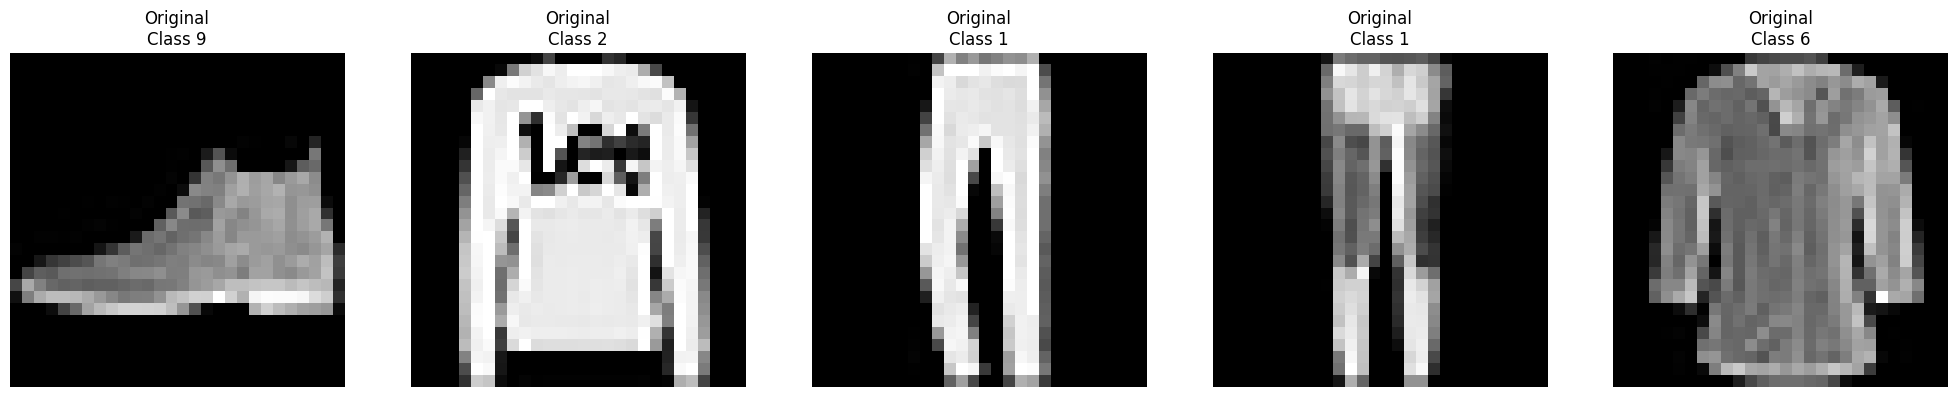

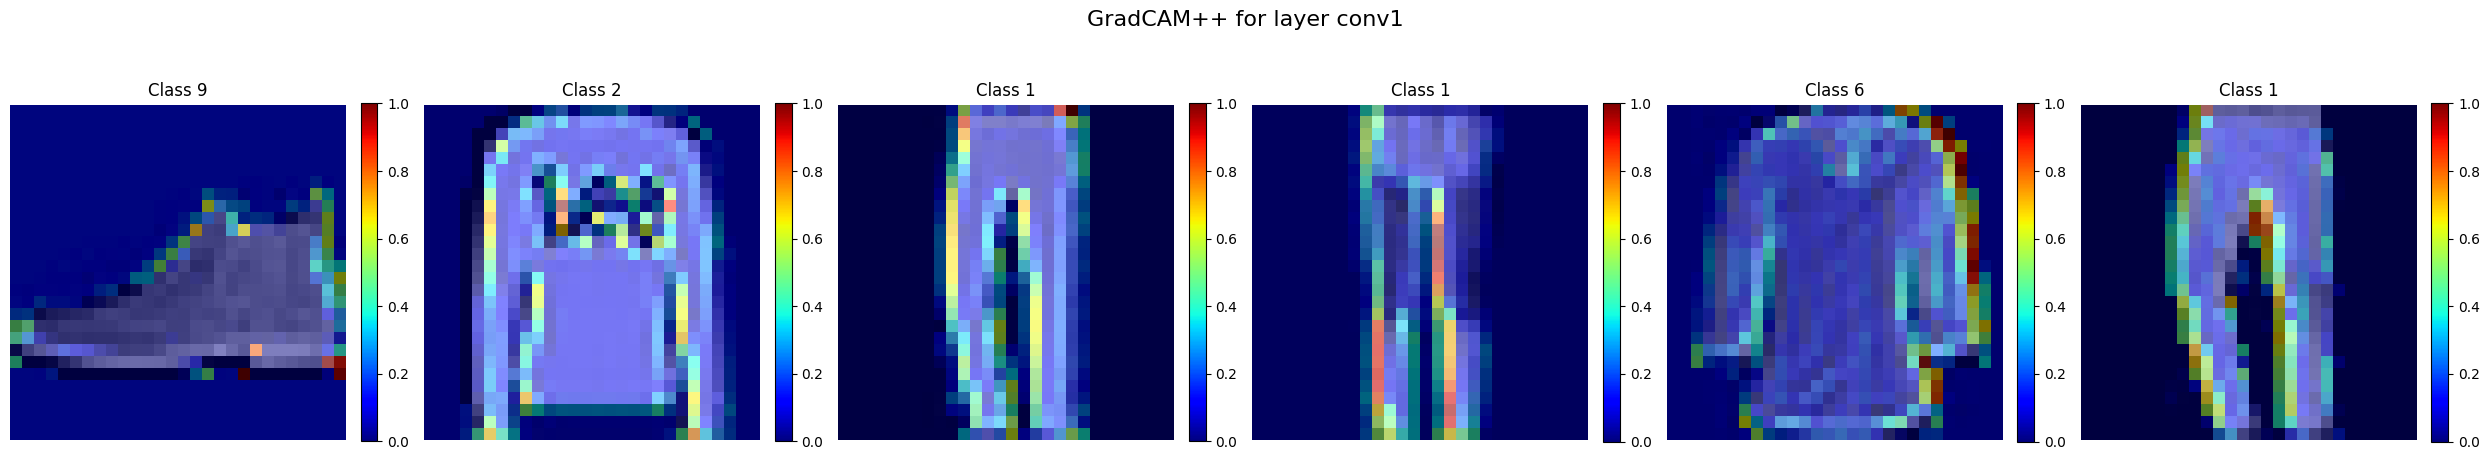

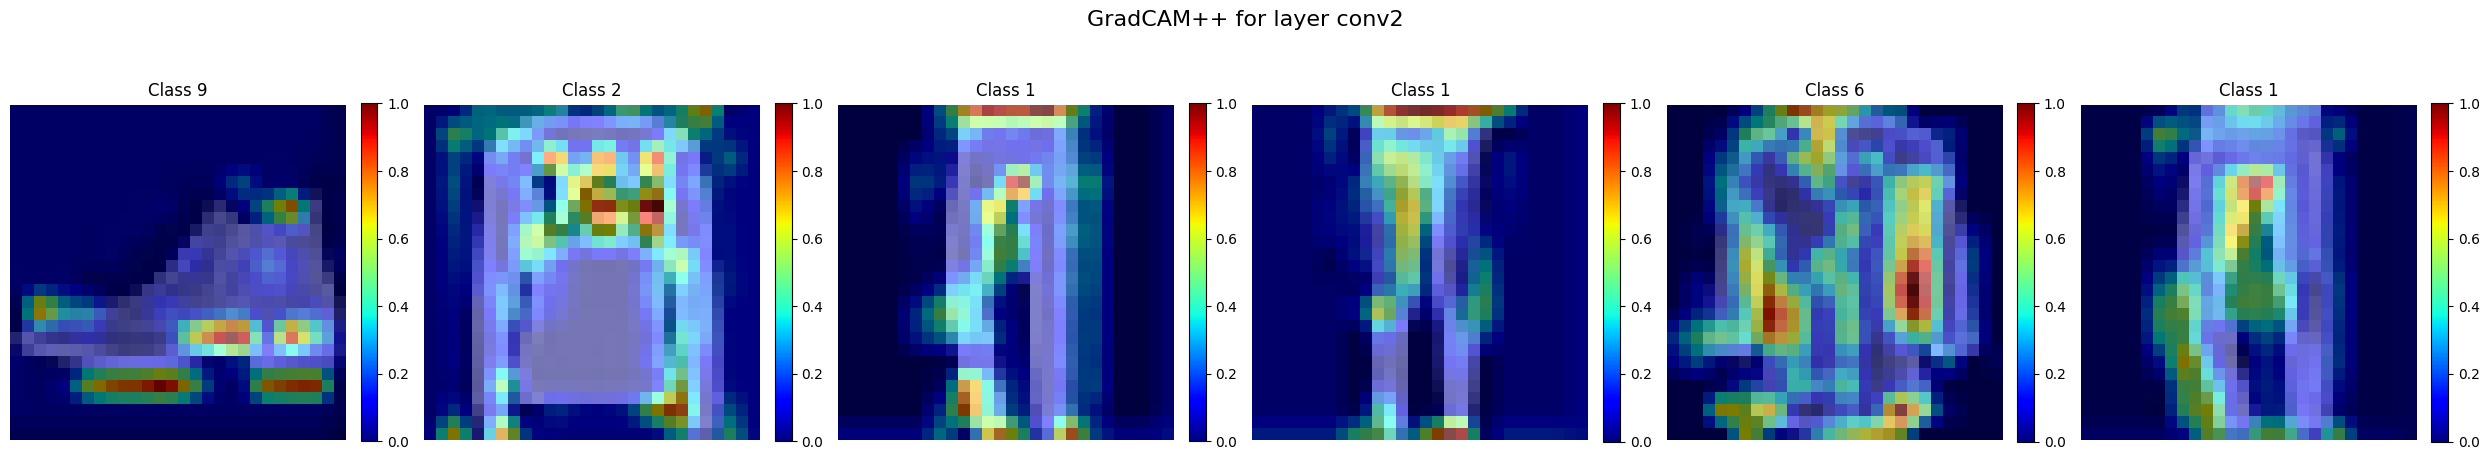

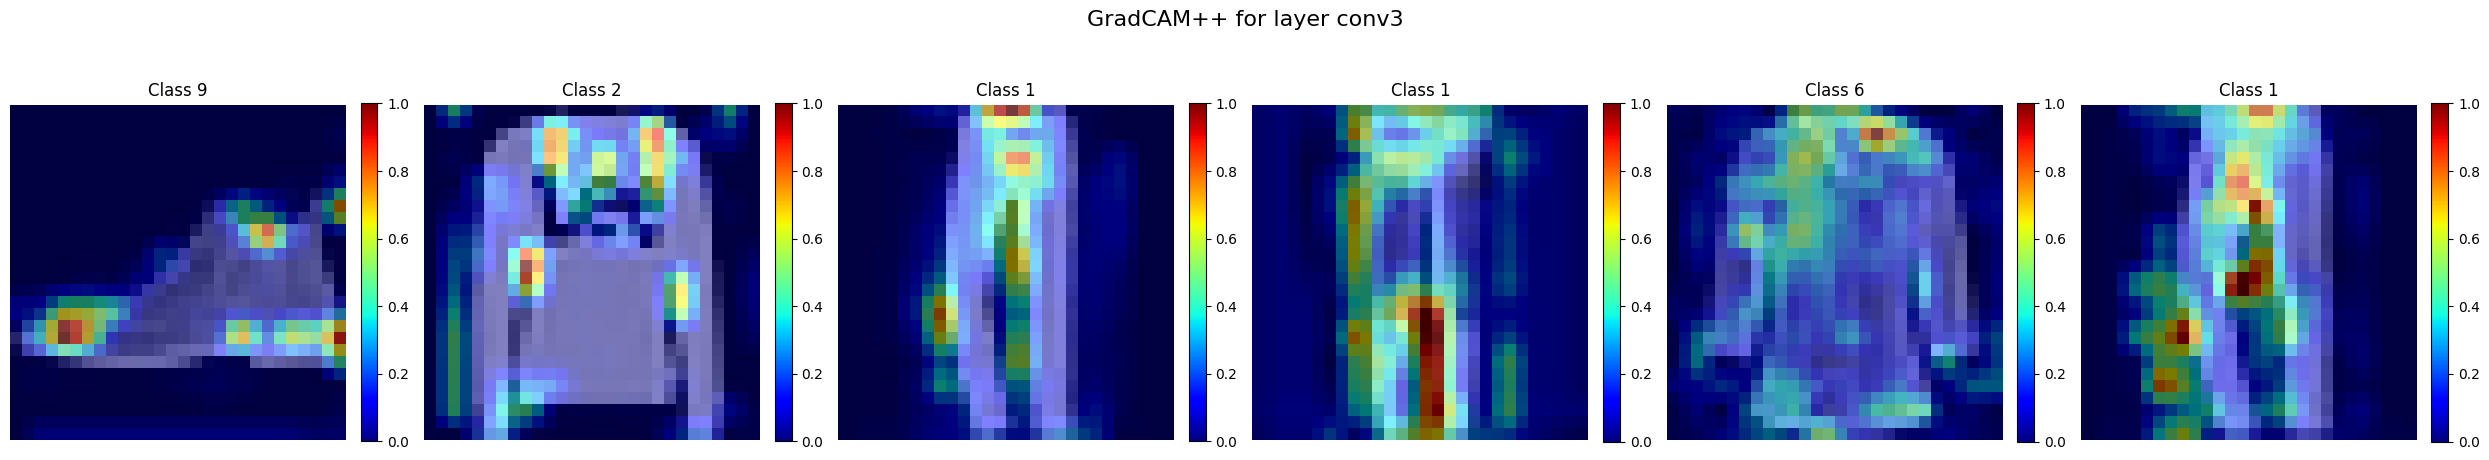

In [17]:
layers = ['conv1', 'conv2', 'conv3']

# Visualizar la imagen original con mayor tamaño
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

num_images = 5
images = X_test[:num_images].reshape(-1, 28, 28, 1)
labels = y_test[:num_images]

for i in range(5):
    image = images[i]
    label = labels[i]
    ax_img = axes[i]
    ax_img.imshow(image.squeeze(), cmap='gray')
    ax_img.axis('off')
    ax_img.set_title(f'Original\nClass {label}')

for layer in layers:
    # Crear el modelo que solo tenga la salida del clasificador
    model_for_gradcam = tf.keras.models.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('softmax_output').output)

    # Crear el objeto GradCAM++
    gradcam = GradcamPlusPlus(model_for_gradcam, model_modifier=ReplaceToLinear(), clone=True)

    # Seleccionar las primeras 6 imágenes del conjunto de prueba
    num_images = 6
    images = X_test[:num_images].reshape(-1, 28, 28, 1)
    labels = y_test[:num_images]

    # Crear una figura con subplots
    fig, axes = plt.subplots(1, 6, figsize=(25, 5))
    fig.suptitle(f'GradCAM++ for layer {layer}', fontsize=16)  # A

    for i, (image, label) in enumerate(zip(images, labels)):
        # Generar el CAM con GradCAM++ usando la capa actual
        cam = gradcam(CategoricalScore(label), image.reshape(1, 28, 28, 1), penultimate_layer=layer)

        # Visualizar el mapa de calor superpuesto en la imagen original
        heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
        ax_heatmap = axes[i]
        ax_heatmap.imshow(image.squeeze(), cmap='gray')
        ax_heatmap.imshow(heatmap, cmap='jet', alpha=0.5)
        ax_heatmap.axis('off')
        ax_heatmap.set_title(f'Class {label}')
        
        # Añadir la barra de colores (color bar)
        norm = plt.Normalize(vmin=cam[0].min(), vmax=cam[0].max())
        sm = plt.cm.ScalarMappable(cmap='jet', norm=norm)
        sm.set_array([])
        fig.colorbar(sm, ax=ax_heatmap, orientation="vertical", fraction=0.046, pad=0.04)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajustar layout para el título
    plt.show()

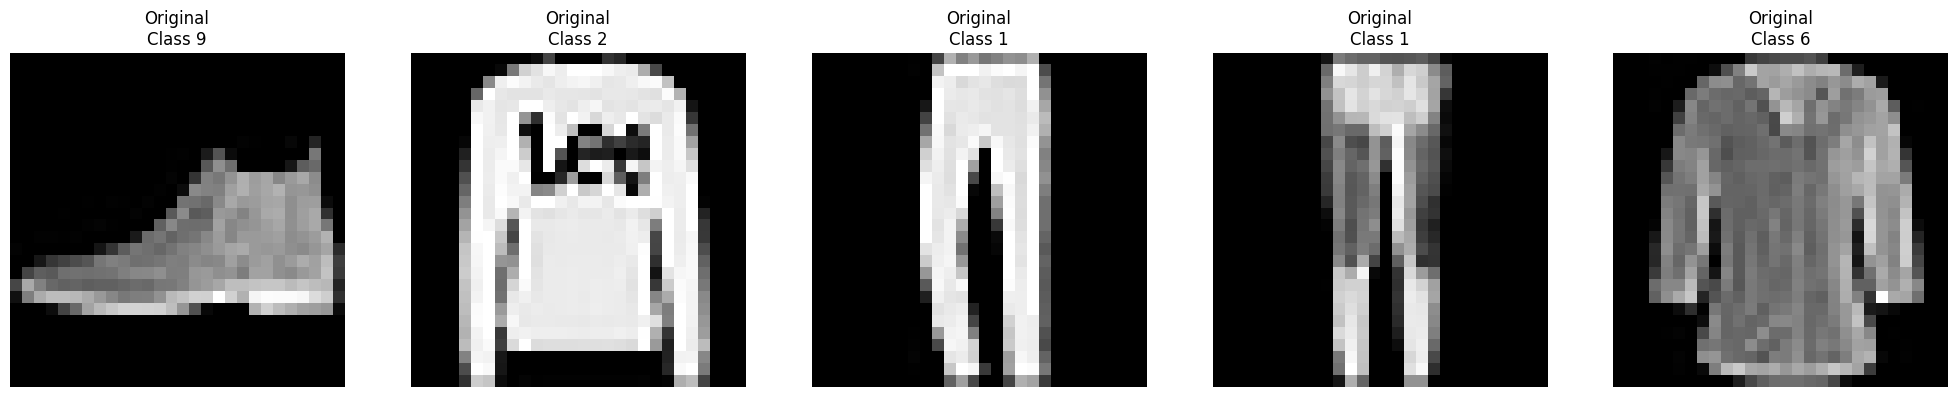

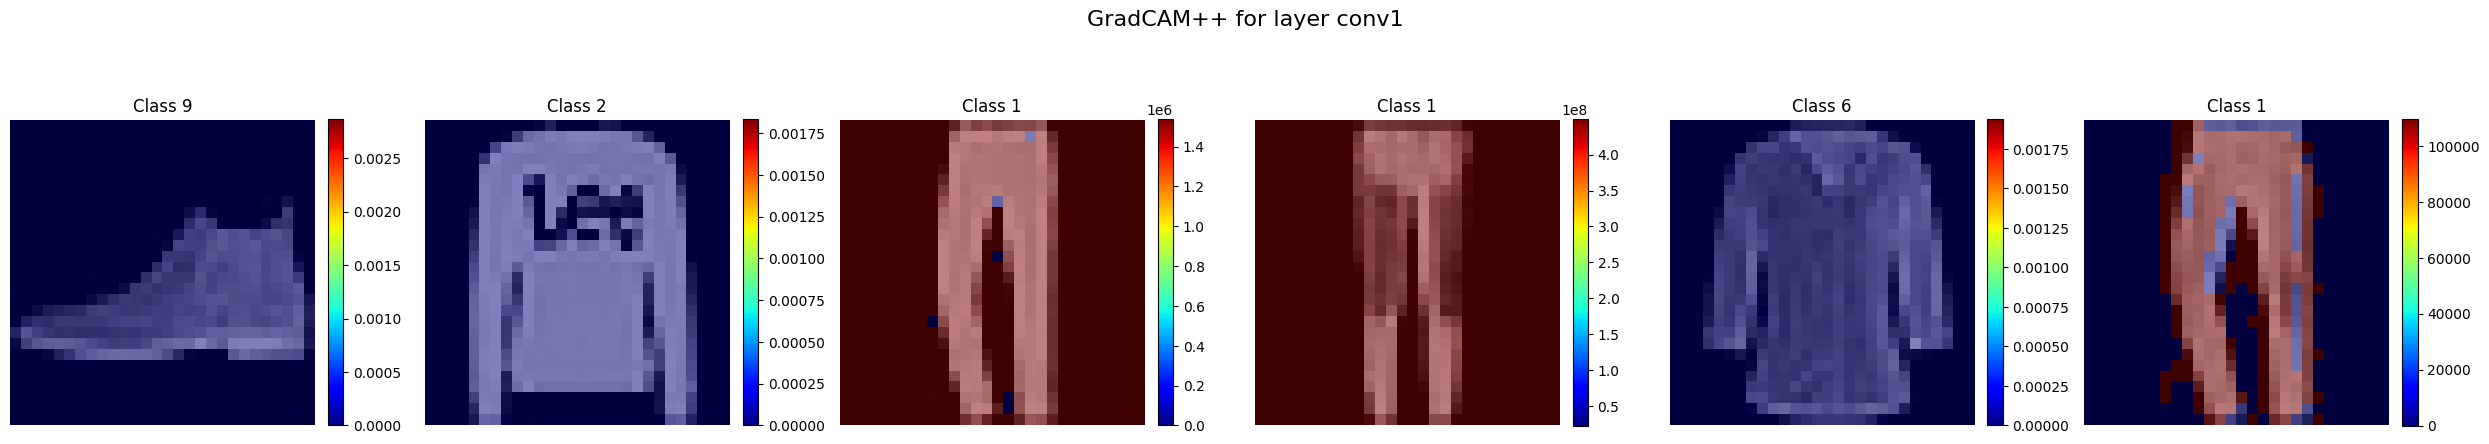

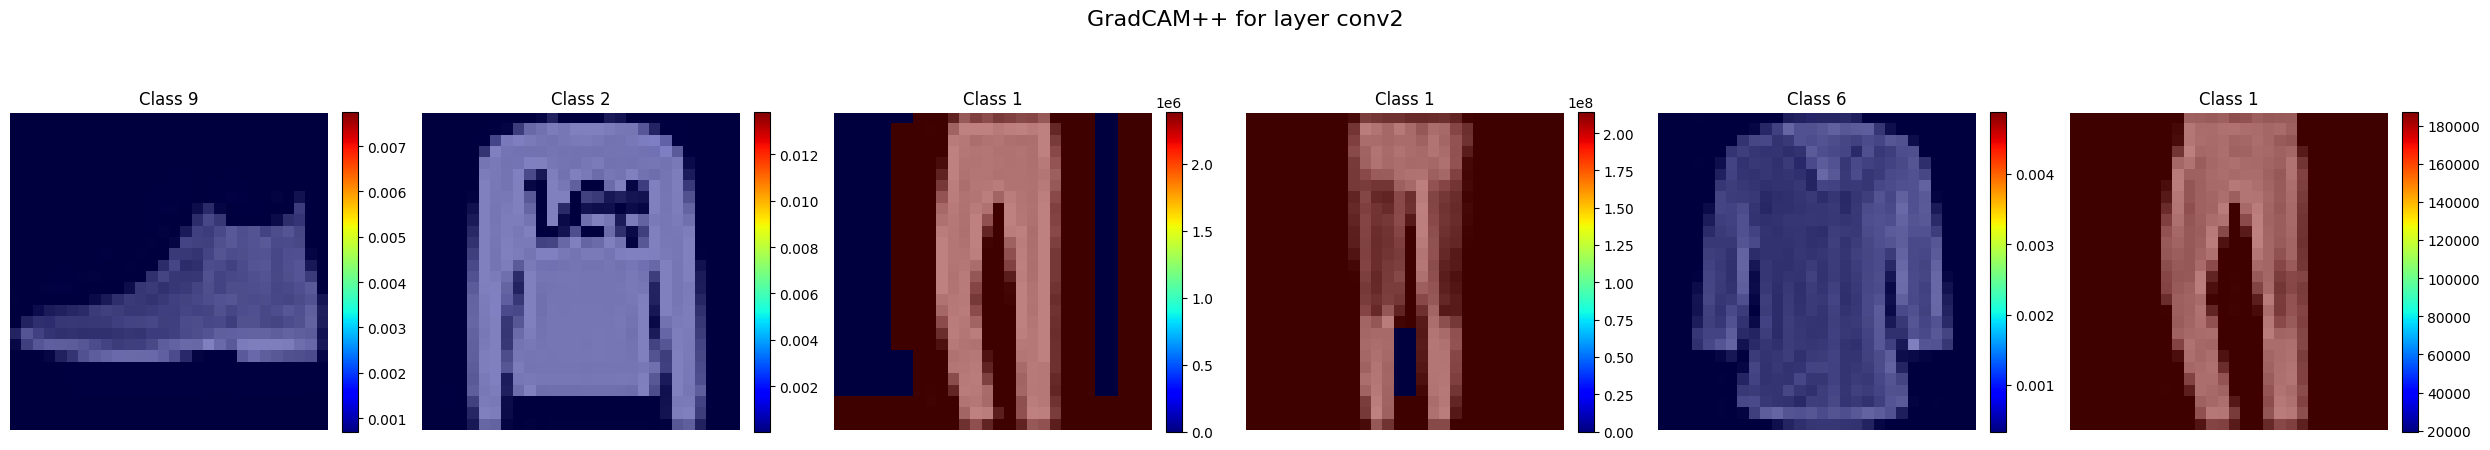

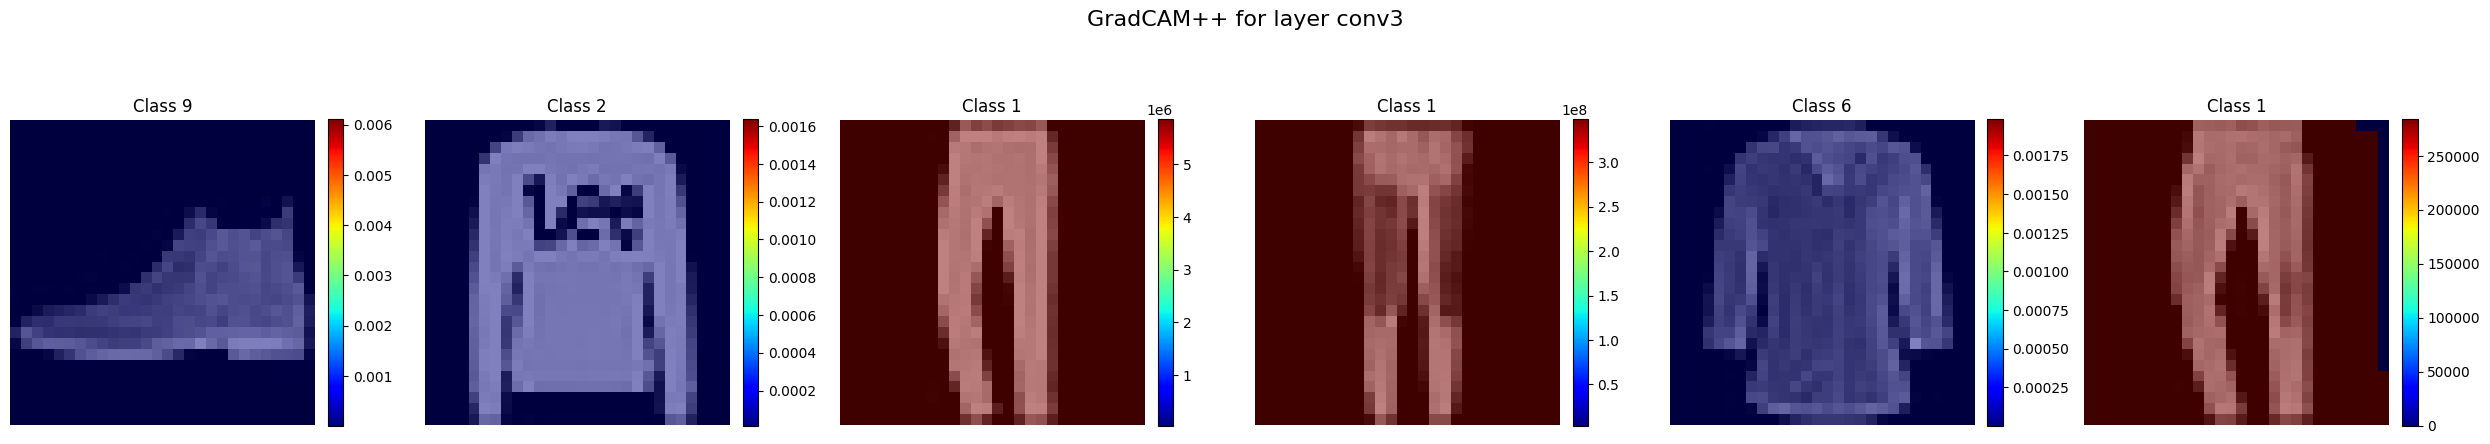

In [18]:
layers = ['conv1', 'conv2', 'conv3']

# Visualizar la imagen original con mayor tamaño
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

num_images = 5
images = X_test[:num_images].reshape(-1, 28, 28, 1)
labels = y_test[:num_images]

for i in range(5):
    image = images[i]
    label = labels[i]
    ax_img = axes[i]
    ax_img.imshow(image.squeeze(), cmap='gray')
    ax_img.axis('off')
    ax_img.set_title(f'Original\nClass {label}')

for layer in layers:
    # Crear el modelo que solo tenga la salida del clasificador
    model_for_gradcam = tf.keras.models.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('softmax_output').output)

    # Crear el objeto GradCAM++
    gradcam = GradcamPlusPlus(model_for_gradcam, model_modifier=ReplaceToLinear(), clone=True)

    # Seleccionar las primeras 6 imágenes del conjunto de prueba
    num_images = 6
    images = X_test[:num_images].reshape(-1, 28, 28, 1)
    labels = y_test[:num_images]

    # Crear una figura con subplots
    fig, axes = plt.subplots(1, 6, figsize=(25, 5))
    fig.suptitle(f'GradCAM++ for layer {layer}', fontsize=16)  # Añadir título con el nombre de la capa

    for i, (image, label) in enumerate(zip(images, labels)):
        # Generar el CAM con GradCAM++ usando la capa actual
        cam = gradcam(CategoricalScore(1), image.reshape(1, 28, 28, 1), penultimate_layer=layer, normalize_cam = False)
        
        #NOTA: EDITAR CATEGORICAL POR 0 Y NORMALIZE_CAM P

        # Visualizar el mapa de calor superpuesto en la imagen original
        heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)
        ax_heatmap = axes[i]
        ax_heatmap.imshow(image.squeeze(), cmap='gray')
        ax_heatmap.imshow(heatmap, cmap='jet', alpha=0.5)
        ax_heatmap.axis('off')
        ax_heatmap.set_title(f'Class {label}')
        
        # Añadir la barra de colores (color bar)
        norm = plt.Normalize(vmin=cam[0].min(), vmax=cam[0].max())
        sm = plt.cm.ScalarMappable(cmap='jet', norm=norm)
        sm.set_array([])
        fig.colorbar(sm, ax=ax_heatmap, orientation="vertical", fraction=0.046, pad=0.04)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajustar layout para el título
    plt.show()